In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skopt import gp_minimize
from skopt.space import Real, Integer
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import time

from pandas.tseries.offsets import MonthEnd

from pandas.tseries.offsets import BDay

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

In [2]:
#tickers = ['SPY', 'QQQ', 'VTI', 'IWM', 'EFA', 'EEM', 'GLD', 'SLV', 'USO', 'XLF']
#tickers = ['SPY', 'QQQ', 'VTI']
#tickers = ['SPY']

#start_date, end_date = '2000-01-01', '2024-05-01'
#train_start_date, train_end_date, test_start_date, test_end_date, prediction_start_date = start_date,'2014-01-01', '2014-01-01', '2024-01-01', '2024-01-01'
#prediction_dates=['2024-01-01','2024-02-01','2024-03-01', '2024-04-01']

In [3]:
def data_loading(ticker_symbol, start_date, end_date):
    # Fetch the ETF data from Yahoo Finance for the period from 2010-01-01 to 2024-01-01
    etf_data = yf.Ticker(ticker_symbol)
    etf_history = etf_data.history(start=start_date, end=end_date)
    etf_history.index = etf_history.index.tz_localize(None)
    return etf_history, etf_data
    
#etf_history,etf_data = data_loading('SPY', start_date, end_date)
#etf_history.head(10)

In [4]:
#etf_history.tail(10)

In [5]:
#Function to derive the predictor columns
def etf_predictors(etf_history,  start_date, end_date, etf_data, benchmark_ticker = '^GSPC' ):
    
    # Calculate Daily Returns
    etf_history['Daily Return'] = etf_history['Close'].pct_change()

    # Calculate 21-Day Volatility (standard deviation of daily returns, annualized)
    etf_history['Volatility'] = etf_history['Daily Return'].rolling(window=21).std() * np.sqrt(252)
    #etf_history['Volatility_ta'] = ta.volatility(etf_history['Close'], window=21, annualize=True)
   
    # Get the ETF info
    etf_info = etf_data.info

    # Retrieve the net asset value price (NAV) and total net assets
    nav_price = etf_info['navPrice']
    total_assets = etf_info['totalAssets']

    # Calculate the number of shares outstanding
    shares_outstanding = total_assets / nav_price

    # Calculate Market Capitalization for each day
    # Market Capitalization = Closing Price * Total Number of Shares Outstanding
    etf_history['Market Cap'] = etf_history['Close'] * shares_outstanding

    total_assets = etf_info['totalAssets']
    total_liabilities = etf_info.get('totalLiabilities', 0)  # Handle the case where total liabilities might not be present
    
    # Calculate Book Value per Share
    book_value_per_share = (total_assets - total_liabilities) / shares_outstanding
    
    # Calculate Price to Book (P/B) Ratio
    etf_history['P/B Ratio'] = etf_history['Close'] / book_value_per_share
    
    # Calculate 1-Month Momentum (21 trading days)
    
    etf_history['Momentum'] = ta.mom(etf_history['Close'], length=21)
    
    benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date)
    benchmark_data['Daily Return'] = benchmark_data['Close'].pct_change()
    #benchmark_data_history = benchmark_data.dropna()
    benchmark_data.head(10)
    
    # Ensure the indices are time zone-naive
    benchmark_data.index = benchmark_data.index.tz_localize(None)
    combined_data = etf_history[['Close']].join(benchmark_data[['Close']], lsuffix='_ETF', rsuffix='_Benchmark')
    combined_data = combined_data.dropna()
    
    # Calculate rolling beta with a 30-day window
    rolling_beta_21 = rolling_beta(combined_data, window=21)

    # Add the rolling beta to the dataframe
    combined_data.loc[:, 'Rolling Beta 21-day'] = rolling_beta_21
    etf_history['Rolling Beta']=combined_data['Rolling Beta 21-day']
    
    # Calculate daily profitability
    daily_profitabilities = []
    previous_nav = None
    for index, row in etf_history.iterrows():
        current_nav = row['Close']  # Current day's NAV
        #print(current_nav)
        if previous_nav is not None:
            daily_profitability = (current_nav - previous_nav) / previous_nav * 100
            daily_profitabilities.append(daily_profitability)
        else:
            daily_profitabilities.append(None)
        previous_nav = current_nav  # Update previous_nav for the next iteration

    # Add daily profitabilities to ETF dataset
    etf_history['Daily Profitability (%)'] = daily_profitabilities
    
    # Calculate the dividend yield for each day
    dividend_yields = []

    for index, row in etf_history.iterrows():
        # Get the dividend payment for the day
        dividend_payment = row['Dividends']

        # Get the current market price of the ETF for the day
        current_price = row['Close']

        # Calculate the dividend yield for the day
        dividend_yield = (dividend_payment / current_price) * 100

        # Append the dividend yield to the list
        dividend_yields.append(dividend_yield)
      
    etf_history['Div yield'] = dividend_yields

    #Volatility
    etf_history['ATR'] = ta.atr(etf_history['High'], etf_history['Low'], etf_history['Close'], length=21)    
    
    # Compute the Relative Volatility Index (RVI)
    rvi = ta.rvi(etf_history['Close'],length=21)
    etf_history['RVI'] = rvi
    
    #Momentum
    rsi_window = 14  # Window size for RSI calculation
    roc_window = 12  # Window size for ROC calculation
    #rsi_window = 21  
    #roc_window = 21  

    

    etf_history['RSI'] = ta.rsi(etf_history['Close'],length=rsi_window)
    # Calculate Rate of Change (ROC)
    etf_history['ROC'] = ta.roc(etf_history['Close'], length=roc_window)
        
    etf_history['log_returns'] = np.log(etf_history['Close'] / etf_history['Close'].shift(1))

    return etf_history

# Function to calculate rolling beta
def rolling_beta(df, window):
    rolling_cov = df['Close_Benchmark'].rolling(window=window).cov(df['Close_ETF'])
    rolling_var = df['Close_Benchmark'].rolling(window=window).var()
    rolling_beta = rolling_cov / rolling_var
    return rolling_beta



In [6]:
#etf_history = etf_predictors(etf_history,  start_date, end_date, etf_data,benchmark_ticker = '^GSPC' )
#etf_history.head(10)

In [7]:

def pre_processing(etf_history, train_start_date, train_end_date, test_start_date, test_end_date, prediction_dates, feature_columns=None, scaling_strategy='StandardScaler', final_end_date='2024-08-01'):
    # Handle missing values and inf replacements
    etf_history.fillna(etf_history.median(), inplace=True)
    etf_history = etf_history.replace(-np.inf, 0)

    # Default feature columns if none are provided
    if feature_columns is None:
        feature_columns = ['Volatility', 'Volume', 'Daily Return', 'Market Cap', 'P/B Ratio', 'Momentum', 
                           'Rolling Beta', 'Daily Profitability (%)', 'ATR', 'RVI', 'RSI', 'ROC']

    # Selecting the features (X) and the target (y)
    X = etf_history.loc[:, feature_columns]
    y = etf_history['log_returns']

    # Split train and test data
    train_data = X.loc[train_start_date:train_end_date]
    test_data = X.loc[test_start_date:test_end_date]
    y_train = y.loc[train_start_date:train_end_date]
    y_test = y.loc[test_start_date:test_end_date]

    # Scaling strategy based on input parameter
    if scaling_strategy == 'StandardScaler':
        scaler = StandardScaler()
    elif scaling_strategy == 'Normalizer':
        scaler = Normalizer()
    else:
        raise ValueError(f"Unsupported scaling strategy: {scaling_strategy}")
    
    # Scaling the train and test data
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Create a dictionary to store forecast data for each prediction period
    forecast_data = {}
    for i, start_date in enumerate(prediction_dates):
        # Determine the end date for each forecast period
        if i < len(prediction_dates) - 1:
            end_date = (pd.to_datetime(start_date) + MonthEnd(0)).strftime('%Y-%m-%d')
        else:
            end_date = final_end_date  # The final end date provided or default

        # Store the forecast data for each period
        forecast_data[f'forecast_data_{i+1}m'] = X.loc[start_date:end_date]

    # Scale the forecast data dynamically
    forecast_data_scaled = {}
    for period_key, period_data in forecast_data.items():
        if not period_data.empty:
            forecast_data_scaled[period_key] = sm.add_constant(scaler.transform(period_data))

    # Add constant to scaled train and test data
    train_data_scaled = sm.add_constant(train_data_scaled)
    test_data_scaled = sm.add_constant(test_data_scaled)

    # Dynamically return the scaled forecast data along with train and test data
    return {
        'train_data_scaled': train_data_scaled,
        'test_data_scaled': test_data_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'X': X,
        'etf_history': etf_history,
        'forecast_data_scaled': forecast_data_scaled,
        'forecast_data': forecast_data
    }


In [8]:
#train_data_scaled, test_data_scaled, y_train, y_test, scaler, X, etf_history, forecast_data_scaled_1m, forecast_data_scaled_2m, forecast_data_scaled_3m, forecast_data_scaled_4m, forecast_data_1m, forecast_data_2m, forecast_data_3m, forecast_data_4m = pre_processing(etf_history, train_start_date, train_end_date, test_start_date, test_end_date, prediction_start_date, prediction_dates)

In [17]:
def build_and_train_lstm_model(epochs, batch_size, units, dropout_rate, learning_rate, train_data_scaled, y_train, validation_split=0.2):
    train_data_reshaped = reshape_for_lstm(train_data_scaled)
    
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=int(units), return_sequences=True, input_shape=(train_data_reshaped.shape[1], train_data_reshaped.shape[2])))
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with return_sequences=False
    model.add(LSTM(units=int(units), return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Adding a Dense hidden layer with ReLU activation
    model.add(Dense(units=int(units/2), activation='relu'))
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
     # Track the start time
    #start_time = time.time()
    
    model.fit(train_data_reshaped, y_train, 
              epochs=int(epochs), 
              batch_size=int(batch_size), 
              validation_split=validation_split, 
              callbacks=[early_stopping],
              verbose=0)
    
    # Calculate time consumed
    #time_consumed = time.time() - start_time
    
    return model



def optimize_hyperparameters(train_data_scaled, y_train, test_data_scaled, y_test):
    def objective_function(epochs, batch_size, units, dropout_rate, learning_rate):
        model = build_and_train_lstm_model(epochs, batch_size, units, dropout_rate, learning_rate, train_data_scaled, y_train)
        test_data_reshaped = reshape_for_lstm(test_data_scaled)
        test_predictions = make_predictions(model, test_data_reshaped)
        mse = mean_squared_error(y_test, test_predictions)
        return -mse  # We return the negative MSE because Bayesian Optimization tries to maximize the function

    # Reduced parameter ranges for faster search
    param_bounds = {
        'epochs': (10, 50),  # Lowered the number of epochs
        'batch_size': (32, 64),  # Limited batch size range
        'units': (50, 100),  # Narrowed the range of units
        'dropout_rate': (0.1, 0.4),  # Lowered the dropout rate range
        'learning_rate': (0.0001, 0.001)  # Narrowed learning rate range
    }
    
    optimizer = BayesianOptimization(
        f=objective_function,
        pbounds=param_bounds,
        verbose=2,
        random_state=42,
    )

    # Reduced the number of iterations for faster optimization
    optimizer.maximize(init_points=5, n_iter=30)  # Fewer initial points and iterations

    best_params = optimizer.max['params']
    return best_params


In [10]:
def make_predictions(model, data_scaled):
    if len(data_scaled.shape) == 2:
        data_scaled = np.reshape(data_scaled, (data_scaled.shape[0], 1, data_scaled.shape[1]))
    elif len(data_scaled.shape) != 3:
        raise ValueError(f"Unexpected shape for input data: {data_scaled.shape}")
    
    predictions = model.predict(data_scaled)
    return predictions

def eval_model(best_model, test_data_scaled, y_test, y_train=None):
    # Reshape test data to match LSTM input requirements
    test_data_reshaped = test_data_scaled.reshape((test_data_scaled.shape[0], 1, test_data_scaled.shape[1]))
    
    # Make predictions
    test_predictions = best_model.predict(test_data_reshaped)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, test_predictions)
    
    # Calculate Mean Absolute Scaled Error (MASE) - Example calculation assuming seasonal period m=1
    naive_forecast = y_test.shift(1).fillna(method='bfill')
    mase = mae / mean_absolute_error(y_test, naive_forecast)
    print("mae: ",mae)
    print("mase: ",mase)
    return mae, mase


In [11]:
# Ensured consistent feature handling and forecasting in predictions
def predictions(model, forecast_data_scaled, forecast_data):
    # Make predictions using the model
    predictions_forecast = make_predictions(model, forecast_data_scaled)
    
    # Create a DataFrame for the predictions with the same index as the forecast data
    forecast_predictions_df = pd.DataFrame(predictions_forecast, columns=["log_returns"], index=forecast_data.index)
    
    # Concatenate the original forecast data with the predictions
    forecast_data_with_predictions = pd.concat([forecast_data, forecast_predictions_df], axis=1)
    
    return forecast_predictions_df, forecast_data_with_predictions

In [12]:
def calculate_mase(y_true, y_pred, naive_forecast):
    # Calculate the MAE of the model's predictions
    mae_model = mean_absolute_error(y_true, y_pred)
    
    # Calculate the MAE of the naive forecast
    mae_naive = mean_absolute_error(y_true, naive_forecast)
    
    # Calculate MASE
    mase = mae_model / mae_naive
    return mase

In [13]:
def reshape_for_lstm(data):
    return np.reshape(data, (data.shape[0], 1, data.shape[1]))  # Reshape into (samples, time_steps, features)


In [14]:
#etf_pred_dict, scores_1m, scores_2m, scores_3m, scores_4m = main(tickers, etf_dict)

In [15]:
tickers = ['SPY', 'QQQ', 'VTI', 'IWM', 'EFA', 'EEM', 'GLD', 'SLV', 'USO', 'XLF']
#tickers = ['SPY', 'QQQ', 'VTI']
#tickers = ['SPY']
                                                           
start_date, end_date = '2000-01-01', '2024-08-01'
train_start_date, train_end_date, test_start_date, test_end_date, prediction_start_date = start_date,'2014-01-01', '2014-01-01', '2024-01-01', '2024-01-01'
prediction_dates=['2024-01-01','2024-02-01','2024-03-01', '2024-04-01','2024-05-01','2024-06-01','2024-07-01']

In [18]:
dict_data = {}
etf_dict = {}
data_with_predictors = []
for i in tickers:
    etf_history,etf_data = data_loading(i, start_date, end_date)
    
    print(etf_data.info.get('longName'), ":",i)
    
    #test_stationarity(etf_history)
    print(" ETF:",i)
    #print(etf_history.head(10))
    #print("################")
    #hist_data.append(etf_history)
    
    etf_history = etf_predictors(etf_history,  start_date, end_date, etf_data,benchmark_ticker = '^GSPC' )
    
    # Call the function
    preprocessed_data = pre_processing(etf_history, train_start_date, train_end_date, test_start_date, test_end_date, prediction_dates)

    # Extract individual components from the returned dictionary
    train_data_scaled = preprocessed_data['train_data_scaled']
    test_data_scaled = preprocessed_data['test_data_scaled']
    y_train = preprocessed_data['y_train']
    y_test = preprocessed_data['y_test']
    scaler = preprocessed_data['scaler']
    X = preprocessed_data['X']
    etf_history = preprocessed_data['etf_history']

    # Optionally, access forecast data for each period
    forecast_data_scaled_1m = preprocessed_data['forecast_data_scaled'].get('forecast_data_1m')
    forecast_data_scaled_2m = preprocessed_data['forecast_data_scaled'].get('forecast_data_2m')
    forecast_data_scaled_3m = preprocessed_data['forecast_data_scaled'].get('forecast_data_3m')
    forecast_data_scaled_4m = preprocessed_data['forecast_data_scaled'].get('forecast_data_4m')
    forecast_data_scaled_5m = preprocessed_data['forecast_data_scaled'].get('forecast_data_5m')
    forecast_data_scaled_6m = preprocessed_data['forecast_data_scaled'].get('forecast_data_6m')
    forecast_data_scaled_7m = preprocessed_data['forecast_data_scaled'].get('forecast_data_7m')
    
    forecast_data_1m = preprocessed_data['forecast_data'].get('forecast_data_1m')
    forecast_data_2m = preprocessed_data['forecast_data'].get('forecast_data_2m')
    forecast_data_3m = preprocessed_data['forecast_data'].get('forecast_data_3m')
    forecast_data_4m = preprocessed_data['forecast_data'].get('forecast_data_4m')
    forecast_data_5m = preprocessed_data['forecast_data'].get('forecast_data_5m')
    forecast_data_6m = preprocessed_data['forecast_data'].get('forecast_data_6m')
    forecast_data_7m = preprocessed_data['forecast_data'].get('forecast_data_7m')
    
    
    # Track the start time
    start_time = time.time()
    
    
    # Optimize hyperparameters
    # Optimize hyperparameters
    best_params = optimize_hyperparameters(train_data_scaled, y_train, test_data_scaled, y_test)
    
    # Extract the best hyperparameters
    best_epochs = int(best_params['epochs'])
    best_batch_size = int(best_params['batch_size'])
    best_units = int(best_params['units'])
    best_dropout_rate = best_params['dropout_rate']
    best_learning_rate = best_params['learning_rate']

    # Train the final model using the best hyperparameters
    best_model = build_and_train_lstm_model(
        epochs=best_epochs, 
        batch_size=best_batch_size, 
        units=best_units, 
        dropout_rate=best_dropout_rate, 
        learning_rate=best_learning_rate, 
        train_data_scaled=train_data_scaled, 
        y_train=y_train
    )
    
     
    
    # Calculate time consumed
    time_consumed = time.time() - start_time
    
    # Print the time consumed
    print(f"Time consumed for training: {time_consumed:.2f} seconds")

    # Evaluate the model
    mae, mase = eval_model(best_model, test_data_scaled, y_test)
    
    print(len(forecast_data_scaled_1m))
    print(len(forecast_data_scaled_2m))
    print(len(forecast_data_scaled_3m))
    print(len(forecast_data_scaled_4m))
    print(len(forecast_data_scaled_5m))
    print(len(forecast_data_scaled_6m))
    print(len(forecast_data_scaled_7m))
    
    forecast_predictions_df_1m, forecast_data_with_predictions_1m = predictions(best_model, forecast_data_scaled_1m, forecast_data_1m)
    forecast_predictions_df_2m, forecast_data_with_predictions_2m = predictions(best_model, forecast_data_scaled_2m, forecast_data_2m)
    forecast_predictions_df_3m, forecast_data_with_predictions_3m = predictions(best_model, forecast_data_scaled_3m, forecast_data_3m)
    forecast_predictions_df_4m, forecast_data_with_predictions_4m = predictions(best_model, forecast_data_scaled_4m, forecast_data_4m)
    forecast_predictions_df_5m, forecast_data_with_predictions_5m = predictions(best_model, forecast_data_scaled_5m, forecast_data_5m)
    forecast_predictions_df_6m, forecast_data_with_predictions_6m = predictions(best_model, forecast_data_scaled_6m, forecast_data_6m)
    forecast_predictions_df_7m, forecast_data_with_predictions_7m = predictions(best_model, forecast_data_scaled_7m, forecast_data_7m)
    
    
    # Add data to dictionary
    # Store the relevant data in a dictionary

    print(forecast_predictions_df_6m)
    print(forecast_predictions_df_7m)
    
    dict_data = {
        "etf_history": etf_history,
        "forecast_data_1m": forecast_data_1m,
        "forecast_data_2m": forecast_data_2m,
        "forecast_data_3m": forecast_data_3m,
        "forecast_data_4m": forecast_data_4m,
        "forecast_data_5m": forecast_data_5m,
        "forecast_data_6m": forecast_data_6m,
        "forecast_data_7m": forecast_data_7m,
        "X": X,
        "y_train_values": y_train , # Assuming this is relevant to the ETF data
        "model results": {"mae": mae,
                          "mase": mase,
                          #"mape": mape
                         },
                         
        "forecast_predictions_df_1m" : forecast_predictions_df_1m['log_returns'].values,
        "forecast_predictions_df_2m" : forecast_predictions_df_2m['log_returns'].values,
        "forecast_predictions_df_3m" : forecast_predictions_df_3m['log_returns'].values,
        "forecast_predictions_df_4m" : forecast_predictions_df_4m['log_returns'].values,
        "forecast_predictions_df_5m" : forecast_predictions_df_5m['log_returns'].values,
        "forecast_predictions_df_6m" : forecast_predictions_df_6m['log_returns'].values,
        "forecast_predictions_df_7m" : forecast_predictions_df_7m['log_returns'].values
    }
    
    # Associate the dictionary with the ETF ticker symbol
    etf_dict[i] = dict_data
     
     

[*********************100%%**********************]  1 of 1 completed

SPDR S&P 500 ETF Trust : SPY
 ETF: SPY
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------


79/79 [==============================] - 0s 430us/step
| 1         | -4.439e-0 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 0s 481us/step
| 2         | -4.446e-0 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 0s 405us/step
| 3         | -0.000145 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 0s 417us/step
| 4         | -0.000151 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 0s 430us/step
| 5         | -0.000166 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 0s 481us/step
| 6         | -3.53e-05 | 36.46     | 0.2708    | 44.72     | 0.0006248 | 85.9      |
79/79 [==============================] - 0s 502us/step
| 7         | -5.086e-0 | 33.25     | 0.1587    | 42.36     | 0.0008437 | 90.94     |
79/79 [======

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


1/1 [==============================] - 0s 9ms/step
            log_returns
Date                   
2024-06-03     0.017454
2024-06-04     0.016866
2024-06-05     0.023392
2024-06-06     0.017087
2024-06-07     0.016517
2024-06-10     0.018334
2024-06-11     0.017903
2024-06-12     0.022014
2024-06-13     0.018125
2024-06-14     0.016278
2024-06-17     0.021553
2024-06-18     0.018093
2024-06-20     0.015819
2024-06-21     0.016379
2024-06-24     0.015228
2024-06-25     0.019255
2024-06-26     0.017077
2024-06-27     0.016845
2024-06-28     0.014939
            log_returns
Date                   
2024-07-01     0.017918
2024-07-02     0.020572
2024-07-03     0.019456
2024-07-05     0.020625
2024-07-08     0.017255
2024-07-09     0.016708
2024-07-10     0.022319
2024-07-11     0.011776
2024-07-12     0.020023
2024-07-15     0.017786
2024-07-16     0.019516
2024-07-17     0.007873
2024-07-18     0.009749
2024-07-19     0.009420
2024-07-22     0.019612
2024-07-23     0.013650
2024-07-24   

[*********************100%%**********************]  1 of 1 completed

Invesco QQQ Trust : QQQ
 ETF: QQQ


|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------
79/79 [==============================] - 0s 432us/step
| 1         | -0.000329 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 0s 505us/step
| 2         | -3.421e-0 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 0s 454us/step
| 3         | -3.356e-0 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 0s 432us/step
| 4         | -0.000169 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 0s 516us/step
| 5         | -0.000127 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 0s 496us/step
| 6         | -0.000156 | 36.46     | 0.2708    | 44.72     | 0.0006

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


            log_returns
Date                   
2024-06-03    -0.001432
2024-06-04    -0.001471
2024-06-05     0.006094
2024-06-06    -0.001434
2024-06-07    -0.001513
2024-06-10     0.000621
2024-06-11     0.001866
2024-06-12     0.003172
2024-06-13     0.001043
2024-06-14     0.002895
2024-06-17     0.003993
2024-06-18    -0.000236
2024-06-20    -0.002488
2024-06-21    -0.000552
2024-06-24    -0.005742
2024-06-25     0.004090
2024-06-26     0.001151
2024-06-27     0.001622
2024-06-28    -0.002115
            log_returns
Date                   
2024-07-01     0.001878
2024-07-02     0.001725
2024-07-03     0.000799
2024-07-05     0.000395
2024-07-08     0.000654
2024-07-09     0.000041
2024-07-10     0.001752
2024-07-11    -0.010284
2024-07-12     0.001397
2024-07-15    -0.000768
2024-07-16    -0.003217
2024-07-17    -0.021507
2024-07-18    -0.012225
2024-07-19    -0.013085
2024-07-22    -0.002515
2024-07-23    -0.009679
2024-07-24    -0.022216
2024-07-25    -0.012834
2024-07-26    -0

[*********************100%%**********************]  1 of 1 completed

Vanguard Total Stock Market Index Fund ETF Shares : VTI
 ETF: VTI
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------


79/79 [==============================] - 0s 494us/step
| 1         | -8.891e-0 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 0s 650us/step
| 2         | -0.000285 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 0s 911us/step
| 3         | -4.745e-0 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 0s 568us/step
| 4         | -0.000209 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 0s 509us/step
| 5         | -0.000266 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 0s 512us/step
| 6         | -4.065e-0 | 38.45     | 0.1002    | 48.55     | 0.0004968 | 50.65     |
79/79 [==============================] - 0s 426us/step
| 7         | -6.825e-0 | 39.26     | 0.1148    | 49.79     | 0.000984  | 50.56     |
79/79 [======

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')
[*********************100%%**********************]  1 of 1 completed

iShares Russell 2000 ETF : IWM
 ETF: IWM
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------


79/79 [==============================] - 0s 501us/step
| 1         | -5.238e-0 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 0s 554us/step
| 2         | -0.000116 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 0s 679us/step
| 3         | -0.000116 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 0s 553us/step
| 4         | -0.000476 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 0s 720us/step
| 5         | -8.936e-0 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 0s 584us/step
| 6         | -0.000456 | 36.46     | 0.2708    | 44.72     | 0.0006248 | 85.9      |
79/79 [==============================] - 0s 585us/step
| 7         | -5.331e-0 | 48.65     | 0.1605    | 26.68     | 0.0006596 | 94.09     |
79/79 [======

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


            log_returns
Date                   
2024-06-03    -0.000955
2024-06-04    -0.010152
2024-06-05     0.011187
2024-06-06    -0.006223
2024-06-07    -0.009338
2024-06-10     0.002076
2024-06-11    -0.001921
2024-06-12     0.010912
2024-06-13    -0.008212
2024-06-14    -0.016125
2024-06-17     0.004127
2024-06-18    -0.000287
2024-06-20    -0.005487
2024-06-21    -0.000924
2024-06-24     0.002031
2024-06-25    -0.001218
2024-06-26    -0.002836
2024-06-27     0.006887
2024-06-28     0.004134
            log_returns
Date                   
2024-07-01    -0.006447
2024-07-02     0.001075
2024-07-03    -0.001444
2024-07-05    -0.002691
2024-07-08     0.003776
2024-07-09    -0.004447
2024-07-10     0.008530
2024-07-11     0.029365
2024-07-12     0.011485
2024-07-15     0.015736
2024-07-16     0.032253
2024-07-17     0.000080
2024-07-18    -0.013284
2024-07-19     0.000779
2024-07-22     0.018097
2024-07-23     0.015176
2024-07-24    -0.013616
2024-07-25     0.016817
2024-07-26     0

[*********************100%%**********************]  1 of 1 completed

iShares MSCI EAFE ETF : EFA
 ETF: EFA
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------


79/79 [==============================] - 0s 560us/step
| 1         | -2.096e-0 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 0s 641us/step
| 2         | -1.437e-0 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 0s 558us/step
| 3         | -8.184e-0 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 0s 542us/step
| 4         | -3.227e-0 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 0s 498us/step
| 5         | -7.511e-0 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 1s 2ms/step
| 6         | -8.523e-0 | 37.67     | 0.3047    | 31.22     | 0.0001749 | 64.26     |
79/79 [==============================] - 0s 683us/step
| 7         | -4.302e-0 | 37.83     | 0.1413    | 44.29     | 0.0001474 | 85.54     |
79/79 [========

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


            log_returns
Date                   
2024-06-03     0.001675
2024-06-04    -0.000680
2024-06-05     0.005511
2024-06-06     0.002734
2024-06-07    -0.008293
2024-06-10    -0.000155
2024-06-11    -0.008352
2024-06-12     0.008916
2024-06-13    -0.010758
2024-06-14    -0.007715
2024-06-17     0.003182
2024-06-18     0.003307
2024-06-20     0.000989
2024-06-21    -0.004362
2024-06-24     0.005723
2024-06-25     0.001553
2024-06-26    -0.004773
2024-06-27     0.000867
2024-06-28     0.000702
            log_returns
Date                   
2024-07-01     0.001264
2024-07-02     0.001919
2024-07-03     0.008669
2024-07-05     0.005403
2024-07-08    -0.002680
2024-07-09    -0.001878
2024-07-10     0.010899
2024-07-11     0.002620
2024-07-12     0.008520
2024-07-15    -0.006243
2024-07-16     0.003574
2024-07-17    -0.003622
2024-07-18    -0.007395
2024-07-19    -0.004305
2024-07-22     0.007937
2024-07-23    -0.004072
2024-07-24    -0.009514
2024-07-25    -0.004457
2024-07-26     0

[*********************100%%**********************]  1 of 1 completed

iShares MSCI Emerging Markets ETF : EEM
 ETF: EEM
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------


79/79 [==============================] - 1s 768us/step
| 1         | -5.248e-0 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 1s 743us/step
| 2         | -2.879e-0 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 1s 483us/step
| 3         | -1.28e-05 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 1s 572us/step
| 4         | -2.358e-0 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 1s 657us/step
| 5         | -2.674e-0 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 1s 566us/step
| 6         | -1.271e-0 | 36.5      | 0.117     | 31.43     | 0.0003557 | 64.16     |
79/79 [==============================] - 1s 608us/step
| 7         | -2.175e-0 | 32.07     | 0.1676    | 26.74     | 0.0005156 | 63.32     |
79/79 [======

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


1/1 [==============================] - 0s 8ms/step
            log_returns
Date                   
2024-06-03     0.010304
2024-06-04    -0.011745
2024-06-05     0.015071
2024-06-06     0.005351
2024-06-07    -0.009098
2024-06-10     0.006389
2024-06-11    -0.001009
2024-06-12     0.009774
2024-06-13    -0.000211
2024-06-14     0.002111
2024-06-17     0.005621
2024-06-18     0.007378
2024-06-20    -0.000091
2024-06-21    -0.001803
2024-06-24     0.001026
2024-06-25    -0.000688
2024-06-26    -0.000823
2024-06-27     0.001318
2024-06-28     0.002217
            log_returns
Date                   
2024-07-01     0.002547
2024-07-02     0.003032
2024-07-03     0.013673
2024-07-05     0.004632
2024-07-08     0.001660
2024-07-09     0.004467
2024-07-10     0.006311
2024-07-11     0.006034
2024-07-12     0.004612
2024-07-15    -0.009057
2024-07-16     0.005354
2024-07-17    -0.014666
2024-07-18    -0.008003
2024-07-19    -0.007737
2024-07-22     0.008318
2024-07-23    -0.006276
2024-07-24   

[*********************100%%**********************]  1 of 1 completed

SPDR Gold Shares : GLD
 ETF: GLD
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------


79/79 [==============================] - 1s 639us/step
| 1         | -4.973e-0 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 1s 753us/step
| 2         | -9.688e-0 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 1s 926us/step
| 3         | -3.856e-0 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 1s 866us/step
| 4         | -1.506e-0 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 1s 788us/step
| 5         | -1.903e-0 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 1s 709us/step
| 6         | -5.646e-0 | 37.67     | 0.3047    | 31.22     | 0.0001749 | 64.26     |
79/79 [==============================] - 1s 612us/step
| 7         | -1.869e-0 | 38.31     | 0.3626    | 30.37     | 0.0009568 | 67.07     |
79/79 [======

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


1/1 [==============================] - 0s 7ms/step
            log_returns
Date                   
2024-06-03     0.004442
2024-06-04    -0.008582
2024-06-05     0.007416
2024-06-06     0.003288
2024-06-07    -0.037166
2024-06-10     0.005575
2024-06-11     0.000710
2024-06-12     0.000839
2024-06-13    -0.007725
2024-06-14     0.007654
2024-06-17    -0.005237
2024-06-18     0.000766
2024-06-20     0.007257
2024-06-21    -0.016135
2024-06-24     0.001184
2024-06-25    -0.004587
2024-06-26    -0.009028
2024-06-27     0.006258
2024-06-28    -0.000827
            log_returns
Date                   
2024-07-01     0.000690
2024-07-02    -0.001088
2024-07-03     0.005922
2024-07-05     0.007534
2024-07-08    -0.010472
2024-07-09     0.000479
2024-07-10     0.001526
2024-07-11     0.011688
2024-07-12    -0.001260
2024-07-15     0.001426
2024-07-16     0.013226
2024-07-17    -0.003950
2024-07-18    -0.006060
2024-07-19    -0.015539
2024-07-22    -0.001022
2024-07-23     0.001270
2024-07-24   

[*********************100%%**********************]  1 of 1 completed

iShares Silver Trust : SLV
 ETF: SLV
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------


79/79 [==============================] - 1s 656us/step
| 1         | -1.075e-0 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 1s 632us/step
| 2         | -2.093e-0 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 1s 637us/step
| 3         | -9.179e-0 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 1s 699us/step
| 4         | -6.809e-0 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 1s 744us/step
| 5         | -1.369e-0 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 1s 859us/step
| 6         | -3.226e-0 | 46.18     | 0.2129    | 24.69     | 0.0005734 | 90.44     |
79/79 [==============================] - 1s 834us/step
| 7         | -1.989e-0 | 52.1      | 0.3526    | 20.2      | 0.0002847 | 73.39     |
79/79 [======

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


1/1 [==============================] - 0s 8ms/step
            log_returns
Date                   
2024-06-03     0.005155
2024-06-04    -0.030185
2024-06-05     0.012272
2024-06-06     0.039678
2024-06-07    -0.066819
2024-06-10     0.014697
2024-06-11    -0.016025
2024-06-12     0.010288
2024-06-13    -0.021564
2024-06-14     0.019698
2024-06-17    -0.004848
2024-06-18     0.000412
2024-06-20     0.036463
2024-06-21    -0.035935
2024-06-24    -0.000056
2024-06-25    -0.021719
2024-06-26    -0.004655
2024-06-27     0.004161
2024-06-28     0.003585
            log_returns
Date                   
2024-07-01     0.008985
2024-07-02     0.004039
2024-07-03     0.029737
2024-07-05     0.020431
2024-07-08    -0.013121
2024-07-09    -0.001303
2024-07-10     0.001801
2024-07-11     0.015134
2024-07-12    -0.019845
2024-07-15    -0.003911
2024-07-16     0.017737
2024-07-17    -0.031590
2024-07-18    -0.017249
2024-07-19    -0.018669
2024-07-22    -0.002905
2024-07-23     0.001254
2024-07-24   

[*********************100%%**********************]  1 of 1 completed

United States Oil Fund, LP : USO
 ETF: USO
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------


79/79 [==============================] - 1s 735us/step
| 1         | -0.000119 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 1s 852us/step
| 2         | -7.119e-0 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 1s 673us/step
| 3         | -0.000153 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 1s 827us/step
| 4         | -0.000157 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 1s 789us/step
| 5         | -9.28e-05 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 1s 920us/step
| 6         | -9.194e-0 | 40.49     | 0.3058    | 47.95     | 0.0003412 | 90.57     |
79/79 [==============================] - 1s 779us/step
| 7         | -0.000108 | 35.11     | 0.3383    | 36.52     | 0.0005938 | 90.11     |
79/79 [======

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


1/1 [==============================] - 0s 8ms/step
            log_returns
Date                   
2024-06-03    -0.035103
2024-06-04    -0.009728
2024-06-05     0.012207
2024-06-06     0.019255
2024-06-07    -0.002148
2024-06-10     0.032818
2024-06-11     0.001464
2024-06-12     0.007806
2024-06-13    -0.002421
2024-06-14     0.005770
2024-06-17     0.022778
2024-06-18     0.012398
2024-06-20     0.010348
2024-06-21    -0.009173
2024-06-24     0.013590
2024-06-25    -0.009669
2024-06-26    -0.001427
2024-06-27     0.014844
2024-06-28    -0.003703
            log_returns
Date                   
2024-07-01     0.023351
2024-07-02    -0.004834
2024-07-03     0.002384
2024-07-05     0.000948
2024-07-08    -0.010468
2024-07-09    -0.007689
2024-07-10     0.010104
2024-07-11     0.006348
2024-07-12    -0.007649
2024-07-15    -0.001211
2024-07-16    -0.013230
2024-07-17     0.019926
2024-07-18    -0.008572
2024-07-19    -0.022801
2024-07-22    -0.003989
2024-07-23    -0.012280
2024-07-24   

[*********************100%%**********************]  1 of 1 completed

The Financial Select Sector SPDR Fund : XLF
 ETF: XLF


|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------------------
79/79 [==============================] - 1s 810us/step
| 1         | -7.56e-06 | 43.99     | 0.3852    | 39.28     | 0.0006388 | 57.8      |
79/79 [==============================] - 1s 1ms/step
| 2         | -7.241e-0 | 36.99     | 0.1174    | 44.65     | 0.000641  | 85.4      |
79/79 [==============================] - 1s 607us/step
| 3         | -2.247e-0 | 32.66     | 0.391     | 43.3      | 0.0002911 | 59.09     |
79/79 [==============================] - 1s 846us/step
| 4         | -1.589e-0 | 37.87     | 0.1913    | 30.99     | 0.0004888 | 64.56     |
79/79 [==============================] - 1s 899us/step
| 5         | -7.764e-0 | 51.58     | 0.1418    | 21.69     | 0.0004297 | 72.8      |
79/79 [==============================] - 1s 940us/step
| 6         | -8.11e-06 | 36.46     | 0.2708    | 44.72     | 0.000624

/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_14867/3520284570.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = y_test.shift(1).fillna(method='bfill')


1/1 [==============================] - 0s 38ms/step
            log_returns
Date                   
2024-06-03     0.004056
2024-06-04     0.005083
2024-06-05     0.011036
2024-06-06     0.007594
2024-06-07     0.011698
2024-06-10     0.004478
2024-06-11    -0.001794
2024-06-12     0.006270
2024-06-13     0.005735
2024-06-14     0.003159
2024-06-17     0.012153
2024-06-18     0.010248
2024-06-20     0.010374
2024-06-21     0.003172
2024-06-24     0.013871
2024-06-25     0.001093
2024-06-26     0.001763
2024-06-27     0.005692
2024-06-28     0.010164
            log_returns
Date                   
2024-07-01     0.009079
2024-07-02     0.015221
2024-07-03     0.003971
2024-07-05     0.006285
2024-07-08     0.004055
2024-07-09     0.012860
2024-07-10     0.009905
2024-07-11     0.013801
2024-07-12     0.011034
2024-07-15     0.020478
2024-07-16     0.018369
2024-07-17     0.015775
2024-07-18    -0.000811
2024-07-19     0.000013
2024-07-22     0.013627
2024-07-23     0.011152
2024-07-24  

In [19]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        return 0
    
    # Calculate Sharpe ratio
    sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1

def calculate_sortino_ratio(log_returns, target_log_return=0.0):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    #sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    epsilon = 1e-8
    
    # Add epsilon to downside_deviation to prevent division by zero
    #if downside_deviation == 0:
     #   return np.nan  # Return NaN if downside deviation is zero
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


In [20]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    forecasted_mean = np.mean(forecasted_values)
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / std_forecast
    rachev_normalized = (rachev_ratio - mean_rachev) / std_rachev
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / std_sharpe
    
    sortino_normalized = (sortino_ratio - mean_sortino) / std_sortino
    #epsilon = 1e-8
    #sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    

    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / std_volatility_clustering
    
    score = forecasted_mean_normalized - (risk_percentage * rachev_normalized) + sharpe_normalized + sortino_normalized - volatility_clustering_normalized
    return score


In [21]:
def process_etf_data(tickers, etf_dict):
    etf_pred_dict = {}

    # Determine the forecast periods dynamically from the etf_dict
    sample_etf = next(iter(etf_dict.values()))
    forecast_periods = [key.split('_')[-1] for key in sample_etf.keys() if key.startswith('forecast_predictions_df')]

    for etf_name in tickers:
        etf_pred_dict[etf_name] = {f"returns_{period}": etf_dict[etf_name][f"forecast_predictions_df_{period}"] for period in forecast_periods}

        for period in forecast_periods:
            returns = etf_pred_dict[etf_name][f"returns_{period}"]
            etf_pred_dict[etf_name][f"rachev_ratio_{period}"] = calculate_rachev_ratio(returns)
            etf_pred_dict[etf_name][f"sharpe_ratio_{period}"] = calculate_sharpe_ratio(returns)
            etf_pred_dict[etf_name][f"sortino_ratio_{period}"] = calculate_sortino_ratio(returns)
            #etf_pred_dict[etf_name][f"sterling_ratio_{period}"] = calculate_sterling_ratio(returns)
            etf_pred_dict[etf_name][f"volatility_clustering_{period}"] = calculate_volatility_clustering(returns)
    
    return etf_pred_dict


In [22]:
def calculate_means_and_stds(etf_pred_dict, forecast_period):
    mean_forecast = np.mean([np.mean(etf_pred_dict[etf][f'returns_{forecast_period}']) for etf in etf_pred_dict])
    std_forecast = np.std([np.mean(etf_pred_dict[etf][f'returns_{forecast_period}']) for etf in etf_pred_dict])

    rachev_ratios = np.array([etf_pred_dict[etf][f'rachev_ratio_{forecast_period}'] for etf in etf_pred_dict])
    mean_rachev = np.mean(rachev_ratios)
    std_rachev = np.std(rachev_ratios)

    sharpe_ratios = np.array([etf_pred_dict[etf][f'sharpe_ratio_{forecast_period}'] for etf in etf_pred_dict])
    mean_sharpe = np.mean(sharpe_ratios)
    std_sharpe = np.std(sharpe_ratios)
    
    volatility_clustering = np.array([etf_pred_dict[etf][f'volatility_clustering_{forecast_period}'] for etf in etf_pred_dict])
    mean_volatility_clustering = np.mean(volatility_clustering)
    std_volatility_clustering = np.std(volatility_clustering)

    

    print('Fetching Sortino ratios')

    sortino_ratios = np.array([etf_pred_dict[etf][f'sortino_ratio_{forecast_period}'] for etf in etf_pred_dict])
    mean_sortino = np.mean(sortino_ratios)
    std_sortino = np.std(sortino_ratios)

    

    return (mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, mean_volatility_clustering, std_volatility_clustering)


In [23]:
def calculate_scores_for_etfs(etf_pred_dict, forecast_period, risk_percentage):
   
    (mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, mean_volatility_clustering, std_volatility_clustering) = calculate_means_and_stds(etf_pred_dict, forecast_period)
    scores = []
    for etf in etf_pred_dict:
        forecasted_values = etf_pred_dict[etf][f'returns_{forecast_period}']
        rachev_ratio = etf_pred_dict[etf][f'rachev_ratio_{forecast_period}']
        sharpe_ratio = etf_pred_dict[etf][f'sharpe_ratio_{forecast_period}']
        volatility_clustering = etf_pred_dict[etf][f'volatility_clustering_{forecast_period}']
        sortino_ratio_ = etf_pred_dict[etf][f'sortino_ratio_{forecast_period}']
        
        score = calculate_composite_score(forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio_, volatility_clustering, mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, mean_volatility_clustering, std_volatility_clustering)



        scores.append({
            'ETF': etf,
            'Month': forecast_period,
            'RiskPercentage': risk_percentage,
            'Score': score
        })
    
    return scores


In [24]:
def main(tickers, etf_dict):
    etf_pred_dict = process_etf_data(tickers, etf_dict)
    
    risk_percentage = 0.10

    scores_1m = calculate_scores_for_etfs(etf_pred_dict, '1m', risk_percentage)
    scores_2m = calculate_scores_for_etfs(etf_pred_dict, '2m', risk_percentage)
    scores_3m = calculate_scores_for_etfs(etf_pred_dict, '3m', risk_percentage)
    scores_4m = calculate_scores_for_etfs(etf_pred_dict, '4m', risk_percentage)
    scores_5m = calculate_scores_for_etfs(etf_pred_dict, '5m', risk_percentage)
    scores_6m = calculate_scores_for_etfs(etf_pred_dict, '6m', risk_percentage)
    scores_7m = calculate_scores_for_etfs(etf_pred_dict, '7m', risk_percentage)
    
    
    for scores in [scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m]:
        for score in scores:
            print(score)

    return etf_pred_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m

# Example usage
# etf_pred_dict, scores_1m, scores_2m, scores_3m = main(tickers, etf_dict)


In [27]:
etf_pred_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m = main(tickers, etf_dict)

Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
{'ETF': 'SPY', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': 7.074070679492177}
{'ETF': 'QQQ', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -1.306042343231748}
{'ETF': 'VTI', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -7.141225166303591}
{'ETF': 'IWM', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -0.39631026844142325}
{'ETF': 'EFA', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -0.2145960734378518}
{'ETF': 'EEM', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -0.7249916986805425}
{'ETF': 'GLD', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -1.130942583521286}
{'ETF': 'SLV', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': 0.4138710349047414}
{'ETF': 'USO', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': 1.296638364275272}
{'ETF': 'XLF', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': 2.1295279040699944}
{'ETF': 'S

In [28]:
df_scores_1m = pd.DataFrame(scores_1m)
df_scores_2m = pd.DataFrame(scores_2m)
df_scores_3m = pd.DataFrame(scores_3m)
df_scores_4m = pd.DataFrame(scores_4m)
df_scores_5m = pd.DataFrame(scores_5m)
df_scores_6m = pd.DataFrame(scores_6m)
df_scores_7m = pd.DataFrame(scores_7m)

In [29]:
# Select the top 2 ETFs based on scores for 1-month forecast
top_etfs_1m = df_scores_1m.nlargest(2, 'Score')
print("Top 2 ETFs for 1-month forecast:")
print(top_etfs_1m)

# Select the top 2 ETFs based on scores for 2-month forecast
top_etfs_2m = df_scores_2m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 2-month forecast:")
print(top_etfs_2m)

# Select the top 2 ETFs based on scores for 3-month forecast
top_etfs_3m = df_scores_3m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 3-month forecast:")
print(top_etfs_3m)

# Select the top 2 ETFs based on scores for 4-month forecast
top_etfs_4m = df_scores_4m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 4-month forecast:")
print(top_etfs_4m)

# Select the top 2 ETFs based on scores for 5-month forecast
top_etfs_5m = df_scores_5m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 5-month forecast:")
print(top_etfs_5m)

# Select the top 2 ETFs based on scores for 4-month forecast
top_etfs_6m = df_scores_6m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 6-month forecast:")
print(top_etfs_6m)

# Select the top 2 ETFs based on scores for 5-month forecast
top_etfs_7m = df_scores_7m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 7-month forecast:")
print(top_etfs_7m)

Top 2 ETFs for 1-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    1m             0.1  7.074071
9  XLF    1m             0.1  2.129528

Top 2 ETFs for 2-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    2m             0.1  7.456172
8  USO    2m             0.1  2.033492

Top 2 ETFs for 3-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    3m             0.1  6.822137
3  IWM    3m             0.1  1.148192

Top 2 ETFs for 4-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    4m             0.1  7.409826
4  EFA    4m             0.1  0.462152

Top 2 ETFs for 5-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    5m             0.1  7.888954
7  SLV    5m             0.1  1.581118

Top 2 ETFs for 6-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    6m             0.1  8.239882
9  XLF    6m             0.1  1.415190

Top 2 ETFs for 7-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    7m          

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
# Enhanced plot function
def plot_scores_line(df):
    plt.figure(figsize=(14, 8))
    sns.set(style="whitegrid")  # Set the style to white grid for better readability

    # Use a more appealing color palette
    palette = sns.color_palette("husl", len(df['ETF'].unique()))

    # Create the line plot
    sns.lineplot(data=df, x='Month', y='Score', hue='ETF', marker='o', palette=palette, linewidth=2.5)

    # Add a horizontal line at y=0
    plt.axhline(0, color='red', linestyle='--')

    # Enhance the title and labels
    plt.title('ETF Scores Over Different Months', fontsize=16, weight='bold')
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Score', fontsize=14)

    # Adjust the legend
    plt.legend(title='ETF', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    # Highlight points and add annotations for key scores
    for etf in df['ETF'].unique():
        subset = df[df['ETF'] == etf]
        for x, y in zip(subset['Month'], subset['Score']):
            plt.text(x, y, f'{y:.2f}', fontsize=9, ha='center')

    plt.tight_layout()
    plt.show

/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/seab

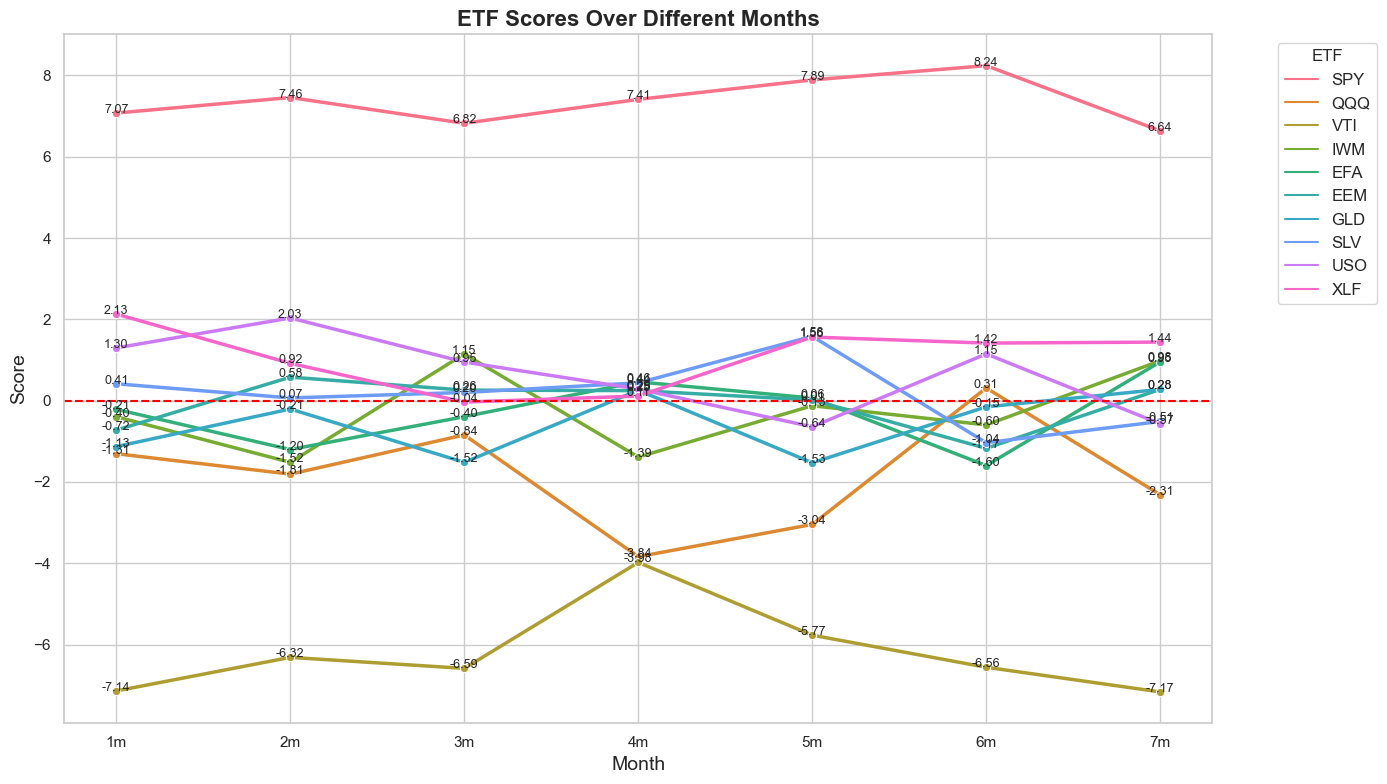

In [31]:
df_scores_all = pd.concat([df_scores_1m, df_scores_2m, df_scores_3m, df_scores_4m, df_scores_5m, df_scores_6m, df_scores_7m])
month_order = ['1m', '2m', '3m', '4m', '5m','6m','7m']
df_scores_all['Month'] = pd.Categorical(df_scores_all['Month'], categories=month_order, ordered=True)

plot_scores_line(df_scores_all)


In [32]:
def select_top_etfs(df_scores, forecast_period):
    top_etfs = df_scores.nlargest(2, 'Score')
    print(f"Top 2 ETFs for {forecast_period}-month forecast:")
    print(top_etfs)
    return top_etfs['ETF'].tolist()


In [33]:
def gather_etf_data_for_months(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = pd.to_datetime(start_date).strftime('%Y-%m')
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
            #print(f"Data for {ticker} in {month} gathered.")
    return etf_histories


In [34]:
# Initialize ticker_shares dictionary at the start of the process
ticker_shares = {}

def initialize_shares_for_first_month(top_etfs_1m, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = f'{month}-01'
    
    # Loop through each ETF in the top 2
    for ticker in top_etfs_1m:
        etf_history = etf_histories.get(ticker)
        
        if etf_history is not None:
            # Get the first business day of the month
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            
            # Extract the closing price on the first trading day
            price_on_first_trading_day = etf_history.loc[first_trading_day, 'Close']
            
            # Calculate the number of shares with the provided investment amount
            num_shares = (investment_amount * 0.975)/ price_on_first_trading_day
            print("Shares 1st month: (",investment_amount, " * 0.975)/ (", price_on_first_trading_day ,")")
            # Store the number of shares in the dictionary
            ticker_shares[ticker] = num_shares
            
            # Print the result for each top ETF
            print(f"Ticker: {ticker}, First trading day: {first_trading_day.date()}, Price: {price_on_first_trading_day}, Shares: {num_shares:.2f}")
        else:
            print(f"No data found for {ticker} in {month}")

    # Return the ticker shares dictionary for this month
    return ticker_shares



In [35]:
# Updated portfolio management function to fix the month format issue
def manage_etf_portfolio(top_etfs_previous, top_etfs_current, previous_month, current_month, ticker_shares, gathered_data_per_month):
    # Use the current month directly as it's already a string like '2024-02'
    etf_histories_for_current_month = gathered_data_per_month.get(current_month, {})

    # Extract ETFs as lists to preserve order
    top2etfs_previous = list(top_etfs_previous)
    top2etfs_current = list(top_etfs_current)

    print(f"Top 2 ETFs for {previous_month}: {top2etfs_previous}")
    print(f"Top 2 ETFs for {current_month}: {top2etfs_current}")

    # Step 1: Identify common ETFs (present in both months)
    etfs_common = [etf for etf in top2etfs_previous if etf in top2etfs_current]

    # Step 2: Identify ETFs to sell (present in the previous month but not in the current month)
    etfs_to_sell = [etf for etf in top2etfs_previous if etf not in top2etfs_current]

    # Step 3: Identify ETFs to buy (present in the current month but not in the previous month)
    etfs_to_buy = [etf for etf in top2etfs_current if etf not in top2etfs_previous]

    # Step 4: Sell ETFs that are no longer in the current top ETFs
    total_selling_value = 0
    for etf in etfs_to_sell:
        no_of_shares = ticker_shares.get(etf, 0)
        if no_of_shares > 0:
            # Check if data for the ETF is available in the current month
            if etf in etf_histories_for_current_month:
                first_trading_day_current_month = etf_histories_for_current_month[etf].loc[etf_histories_for_current_month[etf].index[0], 'Close']
                
                selling_value = no_of_shares * first_trading_day_current_month * 0.975
                print("Formula: ",no_of_shares," * ", first_trading_day_current_month,"* 0.975")
                total_selling_value += selling_value  # Sum total selling value
                print(f"Sell {etf}: {no_of_shares:.2f} shares at {first_trading_day_current_month:.2f}. Total value: {selling_value:.2f}  \n")
                del ticker_shares[etf]
            else:
                print(f"Data for {etf} is missing for {current_month}. Skipping sale.")
        else:
            print(f"No shares found for {etf} to sell.")

    # Step 5: Buy new ETFs that were not in the previous month's top ETFs
    for etf in etfs_to_buy:
        if total_selling_value > 0 and etf in etf_histories_for_current_month:
            first_trading_day_new_etf = etf_histories_for_current_month[etf].loc[etf_histories_for_current_month[etf].index[0], 'Close']
            new_shares = (total_selling_value * 0.975) / first_trading_day_new_etf
            print("Formula: ()",total_selling_value," * 0.975)/", first_trading_day_current_month)
            
            print(f"Buy {etf}: {new_shares:.2f} shares at {first_trading_day_new_etf:.2f}. \n")
            ticker_shares[etf] = new_shares
        else:
            print(f"Data for {etf} is missing or no selling value available. Skipping purchase of {etf}.")

    # Step 6: Maintain the order of ETFs in the ticker_shares dictionary based on the current top 2 ETFs
    ordered_ticker_shares = {etf: ticker_shares[etf] for etf in top2etfs_current if etf in ticker_shares}

    print(f"Updated ticker shares after {current_month}: {ordered_ticker_shares}")
    print("")
    return ordered_ticker_shares



### Values for 7th month

### Smoothing

In [36]:
import numpy as np

# Helper function to apply simple moving average smoothing
def smooth_scores(scores, window_size=5):
    if isinstance(scores, list) or isinstance(scores, np.ndarray):
        smoothed_scores = np.convolve(scores, np.ones(window_size) / window_size, mode='valid')
        # Replace padding logic with raw scores for remaining length
        smoothed_scores = list(scores[:len(scores) - len(smoothed_scores)]) + list(smoothed_scores)
        return smoothed_scores
    else:
        raise ValueError("Scores must be a list or numpy array of numerical values.")
        
def main(tickers, etf_dict):
    etf_pred_dict = process_etf_data(tickers, etf_dict)
    
    risk_percentage = 0.10

    # Calculate scores for each forecast period (1m, 2m, etc.)
    scores_1m = calculate_scores_for_etfs(etf_pred_dict, '1m', risk_percentage)
    scores_2m = calculate_scores_for_etfs(etf_pred_dict, '2m', risk_percentage)
    scores_3m = calculate_scores_for_etfs(etf_pred_dict, '3m', risk_percentage)
    scores_4m = calculate_scores_for_etfs(etf_pred_dict, '4m', risk_percentage)
    scores_5m = calculate_scores_for_etfs(etf_pred_dict, '5m', risk_percentage)
    scores_6m = calculate_scores_for_etfs(etf_pred_dict, '6m', risk_percentage)
    scores_7m = calculate_scores_for_etfs(etf_pred_dict, '7m', risk_percentage)

    # Collect all scores for each ETF across different periods
    etf_scores_dict = {}
    forecast_periods = ['1m', '2m', '3m', '4m', '5m', '6m', '7m']
    all_scores = [scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m]

    for scores_list in all_scores:
        for score_dict in scores_list:
            etf = score_dict['ETF']
            if etf not in etf_scores_dict:
                etf_scores_dict[etf] = []
            etf_scores_dict[etf].append(score_dict['Score'])

    # Now apply smoothing to each ETF's scores
    smoothed_scores_dict = {}
    for etf, scores in etf_scores_dict.items():
        smoothed_scores = smooth_scores(scores, window_size=3)  # Apply smoothing with a window size of 3
        smoothed_scores_dict[etf] = smoothed_scores

    # Print the smoothed scores
    for etf, smoothed_scores in smoothed_scores_dict.items():
        print(f"Smoothed scores for {etf}: {smoothed_scores}")

    return etf_pred_dict, smoothed_scores_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m


In [37]:
etf_pred_dict,smoothed_scores_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m = main(tickers, etf_dict)

Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Smoothed scores for SPY: [7.074070679492177, 7.456172022190935, 7.117459817179415, 7.2293783029043555, 7.3736388518909886, 7.846220539216584, 7.588683780946176]
Smoothed scores for QQQ: [-1.306042343231748, -1.8081729072338857, -1.3192794216882124, -2.1635817029883326, -2.5756759579662174, -2.1909159517498336, -1.682776131569064]
Smoothed scores for VTI: [-7.141225166303591, -6.315452081303486, -6.680966115083167, -5.627182298157781, -5.445187066404168, -5.436076043638351, -6.498022869467038]
Smoothed scores for IWM: [-0.39631026844142325, -1.517883730896858, -0.25533384819213817, -0.5859420083679424, -0.12179273173565362, -0.7035255483016314, 0.08578207477905225]
Smoothed scores for EFA: [-0.2145960734378518, -1.2034576779317907, -0.6045294893043485, -0.3789466341379916, 0.04310983951204995, -0.3576371063218009, -0.1937

In [38]:
import pandas as pd

# Create DataFrames from the original scores
df_scores_1m = pd.DataFrame(scores_1m)
df_scores_2m = pd.DataFrame(scores_2m)
df_scores_3m = pd.DataFrame(scores_3m)
df_scores_4m = pd.DataFrame(scores_4m)
df_scores_5m = pd.DataFrame(scores_5m)
df_scores_6m = pd.DataFrame(scores_6m)
df_scores_7m = pd.DataFrame(scores_7m)

# Helper function to update the DataFrame with smoothed scores
def update_dataframe_with_smoothed_scores(df, smoothed_scores_dict, forecast_period):
    # Loop through each row in the DataFrame and update the 'Score' column
    for index, row in df.iterrows():
        etf = row['ETF']
        if etf in smoothed_scores_dict:
            smoothed_score = smoothed_scores_dict[etf][forecast_period]
            df.at[index, 'Score'] = smoothed_score
    return df

# Update each DataFrame with the smoothed scores
df_scores_1m = update_dataframe_with_smoothed_scores(df_scores_1m, smoothed_scores_dict, 0)  # 0 corresponds to 1m
df_scores_2m = update_dataframe_with_smoothed_scores(df_scores_2m, smoothed_scores_dict, 1)  # 1 corresponds to 2m
df_scores_3m = update_dataframe_with_smoothed_scores(df_scores_3m, smoothed_scores_dict, 2)  # 2 corresponds to 3m
df_scores_4m = update_dataframe_with_smoothed_scores(df_scores_4m, smoothed_scores_dict, 3)  # 3 corresponds to 4m
df_scores_5m = update_dataframe_with_smoothed_scores(df_scores_5m, smoothed_scores_dict, 4)  # 4 corresponds to 5m
df_scores_6m = update_dataframe_with_smoothed_scores(df_scores_6m, smoothed_scores_dict, 5)  # 5 corresponds to 6m
df_scores_7m = update_dataframe_with_smoothed_scores(df_scores_7m, smoothed_scores_dict, 6)  # 6 corresponds to 7m


In [39]:
# Select the top 2 ETFs based on scores for 1-month forecast
top_etfs_1m = df_scores_1m.nlargest(2, 'Score')
print("Top 2 ETFs for 1-month forecast:")
print(top_etfs_1m)

# Select the top 2 ETFs based on scores for 2-month forecast
top_etfs_2m = df_scores_2m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 2-month forecast:")
print(top_etfs_2m)

# Select the top 2 ETFs based on scores for 3-month forecast
top_etfs_3m = df_scores_3m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 3-month forecast:")
print(top_etfs_3m)

# Select the top 2 ETFs based on scores for 4-month forecast
top_etfs_4m = df_scores_4m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 4-month forecast:")
print(top_etfs_4m)

# Select the top 2 ETFs based on scores for 5-month forecast
top_etfs_5m = df_scores_5m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 5-month forecast:")
print(top_etfs_5m)

# Select the top 2 ETFs based on scores for 4-month forecast
top_etfs_6m = df_scores_6m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 6-month forecast:")
print(top_etfs_6m)

# Select the top 2 ETFs based on scores for 5-month forecast
top_etfs_7m = df_scores_7m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 7-month forecast:")
print(top_etfs_7m)

Top 2 ETFs for 1-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    1m             0.1  7.074071
9  XLF    1m             0.1  2.129528

Top 2 ETFs for 2-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    2m             0.1  7.456172
8  USO    2m             0.1  2.033492

Top 2 ETFs for 3-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    3m             0.1  7.117460
8  USO    3m             0.1  1.426606

Top 2 ETFs for 4-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    4m             0.1  7.229378
8  USO    4m             0.1  1.089448

Top 2 ETFs for 5-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    5m             0.1  7.373639
7  SLV    5m             0.1  0.739591

Top 2 ETFs for 6-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    6m             0.1  7.846221
9  XLF    6m             0.1  1.030337

Top 2 ETFs for 7-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    7m          

In [40]:
# Define month ranges for data gathering
month_ranges = [
    ('2024-01-01', '2024-01-31'),
    ('2024-02-01', '2024-02-29'),
    ('2024-03-01', '2024-03-31'),
    ('2024-04-01', '2024-04-30'),
    ('2024-05-01', '2024-05-31'),
    ('2024-06-01', '2024-06-30'),
    ('2024-07-01', '2024-07-31')
]

# Step 1: Select Top ETFs for each forecast period
top_etfs_1m = select_top_etfs(df_scores_1m, 1)
top_etfs_2m = select_top_etfs(df_scores_2m, 2)
top_etfs_3m = select_top_etfs(df_scores_3m, 3)
top_etfs_4m = select_top_etfs(df_scores_4m, 4)
top_etfs_5m = select_top_etfs(df_scores_5m, 5)
top_etfs_6m = select_top_etfs(df_scores_6m, 6)
top_etfs_7m = select_top_etfs(df_scores_7m, 7)

# Step 2: Gather historical data for all months
#tickers = list(set(top_etfs_1m + top_etfs_2m + top_etfs_3m + top_etfs_4m))
tickers = list(set(top_etfs_1m + top_etfs_2m + top_etfs_3m + top_etfs_4m + top_etfs_5m + top_etfs_6m + top_etfs_7m))

etf_histories = gather_etf_data_for_months(tickers, month_ranges)

# Verify gathered data
#for month, data in etf_histories.items():
#    print(f"Data for {month}: {data.keys()}")  # Should print tickers for each month

# Step 3: Perform portfolio optimization for each month
# Start with the first month's portfolio
ticker_shares = {}
ticker_shares_per_month = {}

# For January
ticker_shares_1m = initialize_shares_for_first_month(top_etfs_1m, etf_histories['2024-01'], '2024-01', investment_amount=50000)
ticker_shares_per_month['2024-01'] = ticker_shares_1m.copy()

# For February
ticker_shares_2m = manage_etf_portfolio(top_etfs_1m, top_etfs_2m, '2024-01', '2024-02', ticker_shares_1m, etf_histories)
ticker_shares_per_month['2024-02'] = ticker_shares_2m.copy()

# For March
ticker_shares_3m = manage_etf_portfolio(top_etfs_2m, top_etfs_3m, '2024-02', '2024-03', ticker_shares_2m, etf_histories)
ticker_shares_per_month['2024-03'] = ticker_shares_3m.copy()

# For April
ticker_shares_4m = manage_etf_portfolio(top_etfs_3m, top_etfs_4m, '2024-03', '2024-04', ticker_shares_3m, etf_histories)
ticker_shares_per_month['2024-04'] = ticker_shares_4m.copy()

# For May
ticker_shares_5m = manage_etf_portfolio(top_etfs_4m, top_etfs_5m, '2024-04', '2024-05', ticker_shares_4m, etf_histories)
ticker_shares_per_month['2024-05'] = ticker_shares_5m.copy()

# For June
ticker_shares_6m = manage_etf_portfolio(top_etfs_5m, top_etfs_6m, '2024-05', '2024-06', ticker_shares_5m, etf_histories)
ticker_shares_per_month['2024-06'] = ticker_shares_6m.copy()

# For July
ticker_shares_7m = manage_etf_portfolio(top_etfs_6m, top_etfs_7m, '2024-06', '2024-07', ticker_shares_6m, etf_histories)
ticker_shares_per_month['2024-07'] = ticker_shares_7m.copy()

# Debug output for each month's portfolio
for month, shares in ticker_shares_per_month.items():
    print(f"Ticker shares after {month}: {shares}")


Top 2 ETFs for 1-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    1m             0.1  7.074071
9  XLF    1m             0.1  2.129528
Top 2 ETFs for 2-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    2m             0.1  7.456172
8  USO    2m             0.1  2.033492
Top 2 ETFs for 3-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    3m             0.1  7.117460
8  USO    3m             0.1  1.426606
Top 2 ETFs for 4-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    4m             0.1  7.229378
8  USO    4m             0.1  1.089448
Top 2 ETFs for 5-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    5m             0.1  7.373639
7  SLV    5m             0.1  0.739591
Top 2 ETFs for 6-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    6m             0.1  7.846221
9  XLF    6m             0.1  1.030337
Top 2 ETFs for 7-month forecast:
   ETF Month  RiskPercentage     Score
0  SPY    7m             0.1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shares 1st month: ( 50000  * 0.975)/ ( 472.6499938964844 )
Ticker: SPY, First trading day: 2024-01-02, Price: 472.6499938964844, Shares: 103.14
Shares 1st month: ( 50000  * 0.975)/ ( 37.7599983215332 )
Ticker: XLF, First trading day: 2024-01-02, Price: 37.7599983215332, Shares: 1291.05
Top 2 ETFs for 2024-01: ['SPY', 'XLF']
Top 2 ETFs for 2024-02: ['SPY', 'USO']
Formula:  1291.0487862018676  *  38.81999969482422 * 0.975
Sell XLF: 1291.05 shares at 38.82. Total value: 48865.55  

Formula: () 48865.55064920069  * 0.975)/ 38.81999969482422
Buy USO: 689.79 shares at 69.07. 

Updated ticker shares after 2024-02: {'SPY': 103.14186105898224, 'USO': 689.791690943657}

Top 2 ETFs for 2024-02: ['SPY', 'USO']
Top 2 ETFs for 2024-03: ['SPY', 'USO']
Updated ticker shares after 2024-03: {'SPY': 103.14186105898224, 'USO': 689.791690943657}

Top 2 ETFs for 2024-03: ['SPY', 'USO']
Top 2 ETFs for 2024-04: ['SPY', 'USO']
Updated ticker shares after 2024-04: {'SPY': 103.14186105898224, 'USO': 689.79169094

In [41]:
# Define the 7th month start date (adjust year/month as needed)
first_trading_day = '2024-07-31'  # Start date for the 7th month
#end_date = '2024-07-31'  # End date buffer to account for non-trading days

# Fetch first trading day prices for each ETF
first_day_prices = {}
for ticker in ticker_shares_7m:
    # Download historical data within a date range
    data = yf.download(ticker, start=first_trading_day)
    # Get the first available closing price in the data
    first_closing_price = data['Close'].iloc[0] if not data.empty else None
    first_day_prices[ticker] = first_closing_price

# Display the first trading day prices
for ticker, price in first_day_prices.items():
    print(f"{ticker}: First trading day price in 7th month: ${price:.2f}" if price else f"{ticker}: No data available.")
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

SPY: First trading day price in 7th month: $550.81
XLF: First trading day price in 7th month: $43.74


In [42]:
# Calculate the total portfolio value by multiplying shares by their first trading day prices
portfolio_value_7m = sum(shares * first_day_prices[ticker] for ticker, shares in ticker_shares_7m.items() if ticker in first_day_prices)
portfolio_value_7m

114304.81583446506

Processing frame: 1, month: 1m
Processing frame: 1, month: 1m
Processing frame: 2, month: 2m
Processing frame: 3, month: 3m
Processing frame: 4, month: 4m
Processing frame: 5, month: 5m
Processing frame: 6, month: 6m
Processing frame: 7, month: 7m


Processing frame: 1, month: 1m


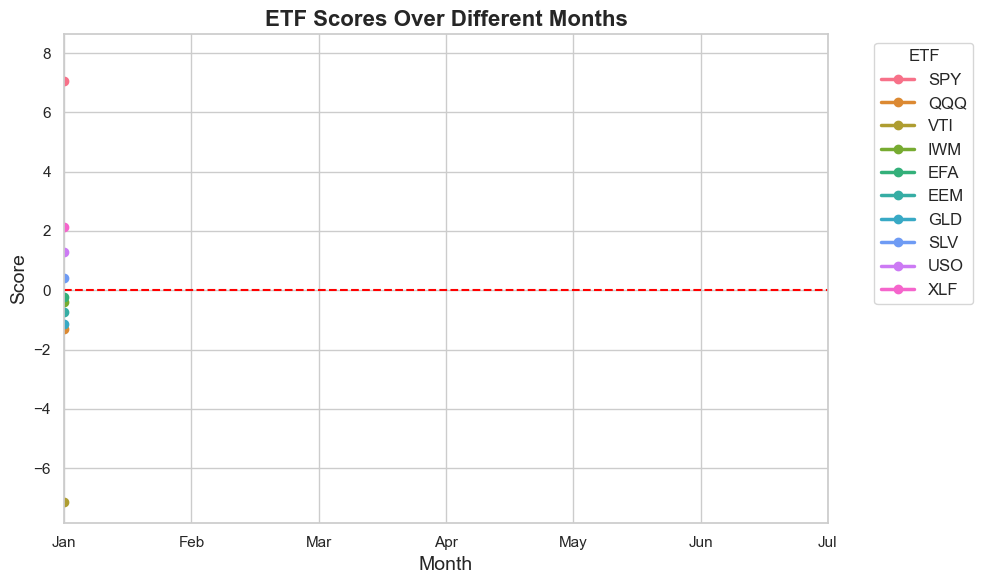

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

# Enhanced plot function with animation and dynamic y-axis
def animate_scores(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    palette = sns.color_palette("husl", len(df['ETF'].unique()))

    # Prepare an empty lineplot for each ETF
    lines = {etf: ax.plot([], [], marker='o', label=etf, color=color, lw=2.5)[0] 
             for etf, color in zip(df['ETF'].unique(), palette)}
    
    # Set up the plot title, labels, and legend
    ax.set_title('ETF Scores Over Different Months', fontsize=16, weight='bold')
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.axhline(0, color='red', linestyle='--')
    ax.legend(title='ETF', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

    # Dynamically calculate the y-axis limits
    y_min = df['Score'].min() * 1.1
    y_max = df['Score'].max() * 1.1

    # Set dynamic y-axis limits
    ax.set_xlim(1, 5)
    ax.set_xticks([1, 2, 3, 4, 5,6,7])

    # Set the x-axis tick labels to three-letter month abbreviations
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul']  # Customize this list based on your data
    ax.set_xticklabels(month_labels)

    ax.set_ylim(y_min, y_max)  # Dynamically set y-limits based on the data

    # Function to update the plot frame by frame
    def update(frame):
        if 1 <= frame + 1 <= 7:
            current_month = month_order[frame]
            print(f"Processing frame: {frame+1}, month: {current_month}")
            subset = df[df['Month'] == current_month]
            
            for etf in subset['ETF'].unique():
                etf_data = subset[subset['ETF'] == etf]
                # Update x and y data for each ETF
                x_data = [month_order.index(month) + 1 for month in df[df['ETF'] == etf]['Month'][:frame+1]]
                y_data = df[df['ETF'] == etf]['Score'][:frame+1]
                lines[etf].set_data(x_data, y_data)

            return list(lines.values())
        else:
            print(f"Frame {frame+1} exceeds the available months.")
            return []

    ani = animation.FuncAnimation(fig, update, frames=len(month_order), interval=1000, blit=False)

    plt.tight_layout()  # Make sure all elements fit without overlapping
    
    return ani

# Prepare the data and order the months
df_scores_all = pd.concat([df_scores_1m, df_scores_2m, df_scores_3m, df_scores_4m, df_scores_5m, df_scores_6m, df_scores_7m])
month_order = ['1m', '2m', '3m', '4m', '5m', '6m', '7m']
df_scores_all['Month'] = pd.Categorical(df_scores_all['Month'], categories=month_order, ordered=True)

# Call the animate function
anim = animate_scores(df_scores_all)

# Display the animation in the notebook
HTML(anim.to_jshtml())


In [44]:
print('HEllo')

HEllo
